# Projet simulation logicielle
* *Rhouch Oussama*
* *Cherki Inssaf*

<img src="figure/model based.png" alt="CS" style="width: 750px;"/>

## Importing libraries

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.io.wavfile import write
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import warnings
import random
import logging
torch.cuda.empty_cache()
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

## Performing preprocessing on the data

##### Unzip the data

In [3]:
zip_file_paths = ['data/data_part1.zip', 'data/data_part2.zip', 'data/data_part3.zip', 'data/data_part4.zip']

for zip_file_path in zip_file_paths:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")

##### Data folders

In [4]:
noise_folder = "data/noise/"
clean_folder = "data/clean/dev-clean"
output_folder = "data/noisy/"
denoising_folder = "data/denoising/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(denoising_folder, exist_ok=True)

### Clean audio data

##### Load clean audio data

In [6]:
# Get the list of clean files
clean_path = []
for folder in os.listdir(clean_folder):
    folder_path = os.path.join(clean_folder, folder)
    if os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    clean_path.append(file_path)

In [7]:
# load clean data
s, s_rate = librosa.load(clean_path[0], sr=16000)

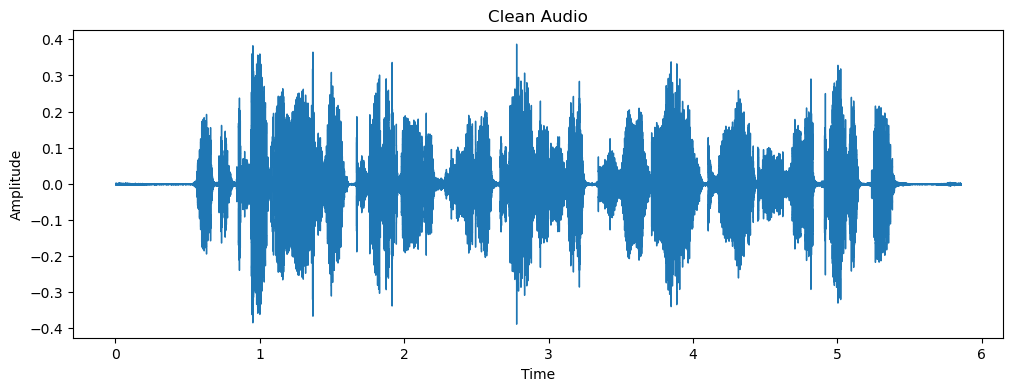

In [8]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(s, sr=s_rate)
plt.title('Clean Audio')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [9]:
write("clean.wav", s_rate, s)

In [10]:
# normalize the clean audio
s_norm = preprocessing.normalize([s])

# Fourier transform
s_stft = librosa.stft(s_norm[0])

# convert to dB
s_stft_db = librosa.amplitude_to_db(abs(s_stft))

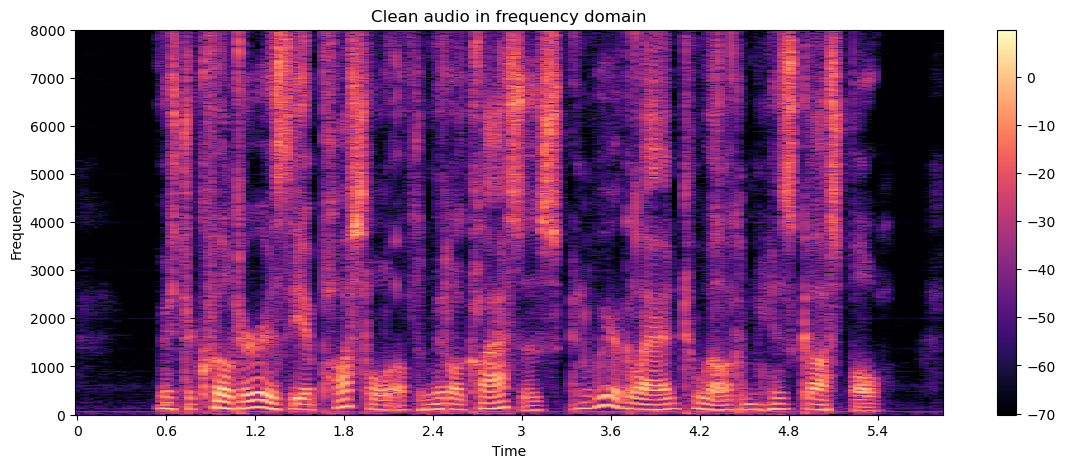

In [11]:
# plot the clean audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(s_stft_db, sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Clean audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [12]:
# Get the list of noise files
noise_file = ""
if os.path.isdir(noise_folder):
        for root, dirs, files in os.walk(noise_folder):
            for file in files:
                if file.endswith(".wav"):
                    noise_file = os.path.join(root, file)

noise_file

'data/noise/babble_16k.wav'

In [13]:
# load noise data
u, u_rate = librosa.load(noise_file, sr=16000)

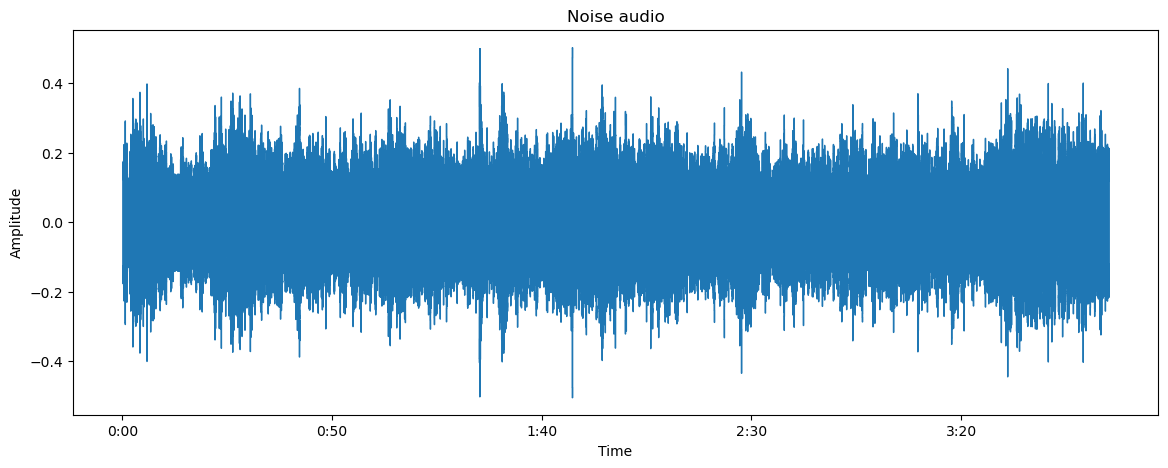

In [14]:
# Plot the noise audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(u, sr=u_rate)
plt.title("Noise audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [15]:
# normalize the clean audio
u_norm = preprocessing.normalize([u[:len(s)]]) 

# Fourier transform
u_stft = librosa.stft(u_norm[0])

# convert to dB
u_stft_db = librosa.amplitude_to_db(abs(u_stft))

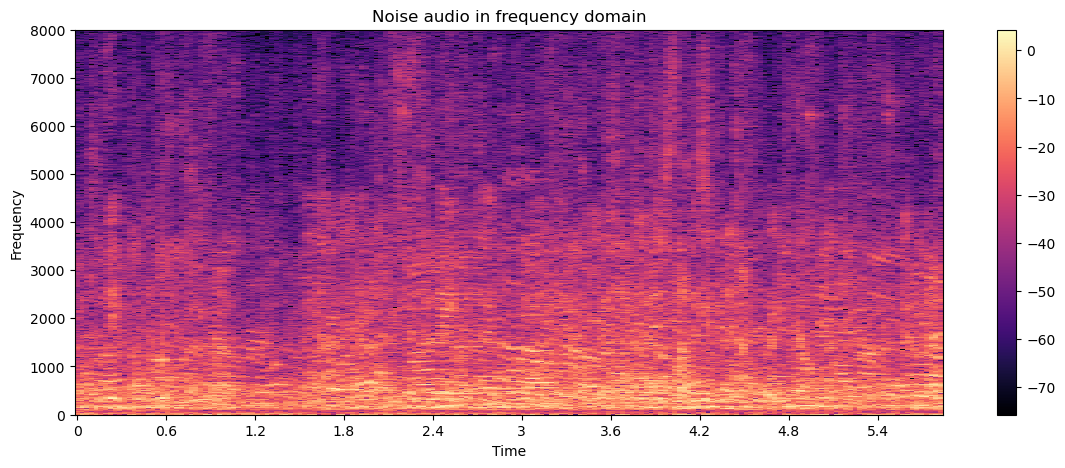

In [16]:
# plot the noise audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(u_stft_db, sr=u_rate, x_axis="time", y_axis="hz")
plt.title("Noise audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [17]:
# mix the clean and noise audio
rsb = 6
alpha = 10**(-rsb/10)

x = s + alpha * u[:len(s)]
x = x.astype(np.float32)

In [18]:
# save the mixed audio
write(os.path.join('', "mixed.wav"), s_rate, x)

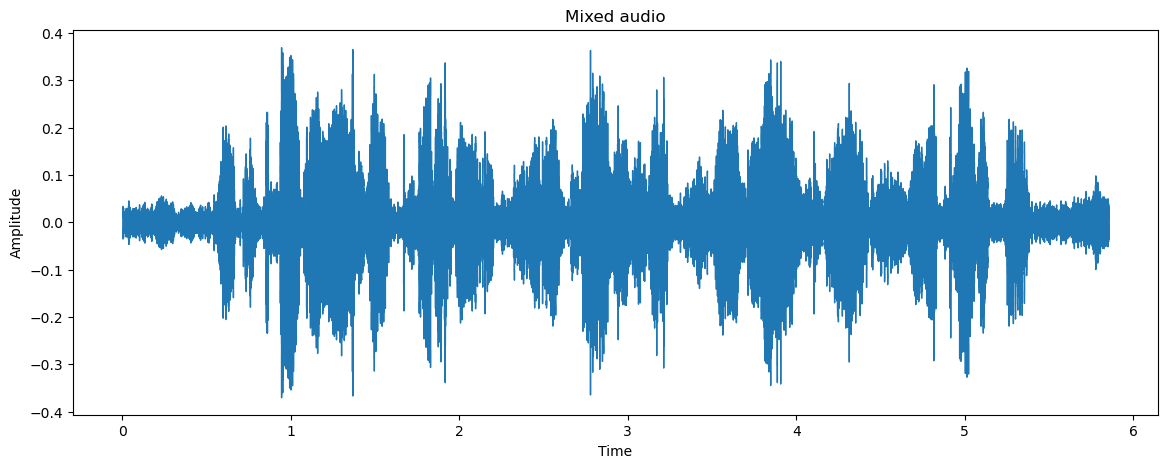

In [19]:
# plot the noisy audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=s_rate)
plt.title("Mixed audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [20]:
# Fourier transform of the noisy audio
x_stft = librosa.stft(x)

# convert to dB
x_stft_db = librosa.amplitude_to_db(abs(x_stft))

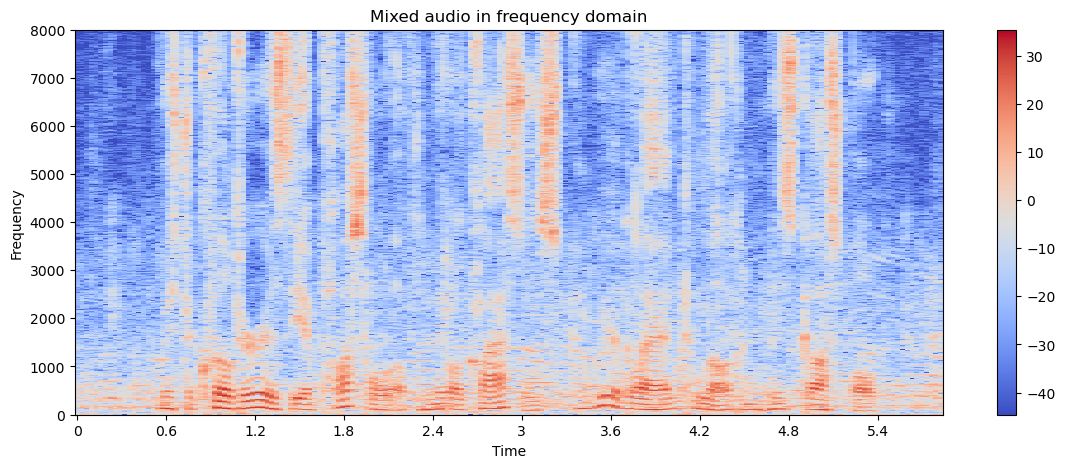

In [21]:
# plot the noisy audio in frequency domain
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_stft_db, sr=s_rate, x_axis="time", y_axis="hz")
plt.title("Mixed audio in frequency domain")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [22]:
s_stft_10s = []
x_stft_10s = []
for i in range(0, len(s_stft)):
    if i % 10 == 0:
        s_stft_10s.append(s_stft[i:i+10])
        x_stft_10s.append(x_stft[i:i+10])

In [23]:
U, _ = librosa.magphase(u_stft)
rms = librosa.feature.rms(S=U)

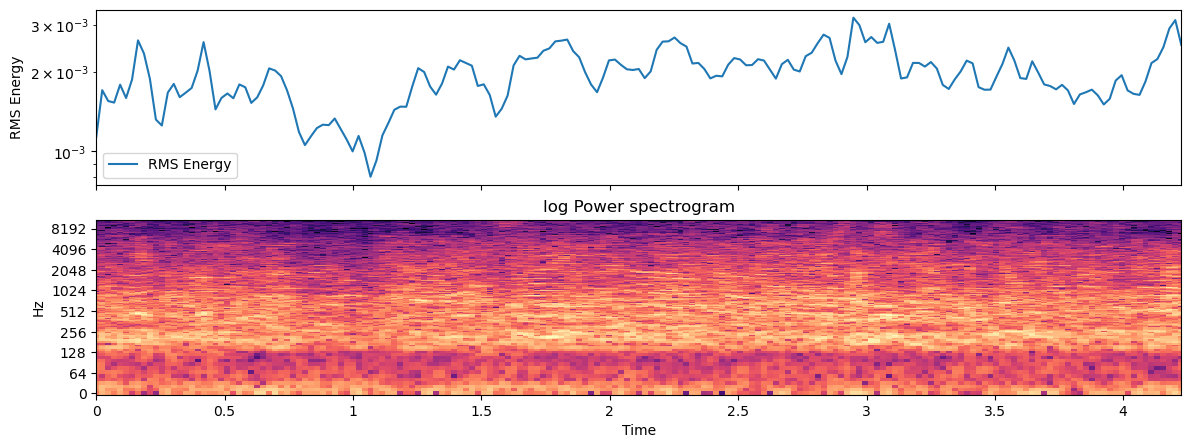

In [24]:
fig, ax = plt.subplots(figsize=(14, 5), nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[], xlim=[times.min(), times.max()], ylabel='RMS Energy')
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(U), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

### Functions

In [25]:
def alpha(RSB):
    return np.sqrt(10**(RSB/10))

In [26]:
def make_noisy(clean_file, noise_file, output_file, RSB_range=(3, 9)):
    s = clean_file
    u, sr = librosa.load(noise_file, sr=None)
    u = np.tile(u, int(np.ceil(len(s) / len(u))))[:len(s)]  # Handle variable audio lengths

    s_tf = np.fft.fft(s)
    u_tf = np.fft.fft(u)

    RSB_value = 6
    alpha_value = alpha(RSB_value)

    x_tf = s_tf + alpha_value * u_tf

    x = np.fft.ifft(x_tf)
    x = x.astype(np.float32)
    x = x / np.max(np.abs(x))  # Normalization

    sf.write(output_file, x, sr)

    return x


def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    audio = librosa.effects.pitch_shift(audio, sr, n_steps=random.uniform(-1, 1))  # Pitch shift augmentation
    return audio

### Preprocessing

In [58]:
class SpeechDataset(Dataset):
    def __init__(self, transform=None):
        self.clean_files = []
        self.noisy_files = []
        self.noise = []
        self.original_length = []
        self.i = 0
        self.transform = transform
        
        for clean_file in clean_path[:10]:
            s, _ = librosa.load(clean_file, sr=None)
            self.clean_files.append(torch.tensor(s))
            self.original_length.append(len(s))
        
        self.max_len = max(self.original_length)
        u, _ = librosa.load(noise_file, sr=None)
        self.noise = u[:self.max_len]
        
        for i in range(len(self.clean_files)):
            self.clean_files[i] = F.pad(self.clean_files[i], (0, self.max_len - len(self.clean_files[i])))
        
        for clean_file in self.clean_files:
            output_path = f"{output_folder}noisy_{self.i}.wav"
            x = make_noisy(clean_file, noise_file, output_path)
            
            self.noisy_files.append(x)
            
            self.i += 1
            
        for i in range(len(self.clean_files)):
            s = self.clean_files[i]
            x = self.noisy_files[i]
            
            self.clean_files[i] = torch.tensor(np.abs(np.fft.fft(s))).to("cpu")
            self.noisy_files[i] = torch.tensor(np.abs(np.fft.fft(x))).to("cpu")
            
    def __len__(self):
        return len(self.clean_files)
    
    def __getitem__(self, idx):
        try:
            noisy, clean = self.noisy_files[idx].float(), self.clean_files[idx].float()
        except IndexError:
            logging.error(f"Index {idx} out of range.")
            raise

        clean_spectrogram = self.to_spectrogram(clean)
        noisy_spectrogram = self.to_spectrogram(noisy)
        
        if self.transform:
            clean_spectrogram = self.transform(clean_spectrogram)
            noisy_spectrogram = self.transform(noisy_spectrogram)

        return noisy_spectrogram, clean_spectrogram

    @staticmethod
    def to_spectrogram(audio):
        # Convert audio to a spectrogram
        if isinstance(audio, torch.Tensor):
            audio = audio.numpy()
            
        S = librosa.feature.melspectrogram(y=audio, sr=22050, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        return S_dB

In [59]:
dataset = SpeechDataset()

In [60]:
input_size = len(dataset.__getitem__(0)[0])
input_size

128

In [61]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [62]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Perceptron

In [63]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # Define your layers here
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, input_size)  # Output size same as input

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation at the last layer
        return x

In [64]:
def compute_mask(clean, noisy, threshold=5):
    """
    Compute a binary mask where 1 indicates a noisy part and 0 indicates clean.
    `threshold` is the dB difference to consider a part as noisy.
    """
    mask = torch.abs(clean - noisy) > threshold
    return mask.float()  # Ensure the mask is in float for computation

In [65]:
def masked_mse_loss(output, target, mask):
    """
    Compute the MSE loss only on the masked parts of the spectrogram.
    """
    loss = F.mse_loss(output * mask, target * mask, reduction='sum') / mask.sum()
    return loss

In [66]:
MLP_model = MLP(input_size)

In [67]:
summary(MLP_model, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          66,048
            Linear-2                  [-1, 512]         262,656
            Linear-3                  [-1, 128]          65,664
Total params: 394,368
Trainable params: 394,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


In [68]:
for epoch in range(num_epochs):
    MLP_model.train()
    for noisy_spectrogram, clean_spectrogram in train_loader:
        # Flatten the spectrograms for MLP
        noisy_spectrogram = noisy_spectrogram.view(noisy_spectrogram.size(0), -1)
        clean_spectrogram = clean_spectrogram.view(clean_spectrogram.size(0), -1)

        # Compute the mask
        mask = compute_mask(clean_spectrogram, noisy_spectrogram)

        # Forward pass
        outputs = MLP_model(noisy_spectrogram)

        # Compute loss with mask
        loss = masked_mse_loss(outputs, clean_spectrogram, mask)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x117632 and 128x512)

In [25]:
def validate(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0

    with torch.no_grad():  # No need to track gradients for validation
        for noisy, clean in loader:
            noisy = noisy.float()
            clean = clean.float()

            # Forward pass through the network
            predicted_mask = model(noisy)

            # Compute the true mask
            true_mask = compute_mask(noisy, clean)

            # Compute loss using the true mask and the predicted mask
            loss = criterion(predicted_mask, true_mask)

            # Accumulate the validation loss
            validation_loss += loss.item()

    # Compute the average loss
    validation_loss /= len(loader.dataset)
    return validation_loss

In [26]:
# Perform the validation
val_loss = validate(MLP_model, test_loader, criterion)
print(f'Validation Loss: {val_loss:.6f}')

Validation Loss: 0.216946


In [28]:
def denoise_audio(model, noisy, sr=16000):
    # Compute the predicted mask
    noisy = noisy.float()
    noisy = F.pad(noisy, (0,  - len(noisy)))
    predicted_mask = model(noisy)

    # Convert the predicted mask from PyTorch Tensor to numpy array and transpose it
    predicted_mask = predicted_mask.detach().numpy().T

    # Apply the mask to the noisy audio data
    denoised_audio = noisy * predicted_mask

    # Compute the magnitude of the denoised audio
    denoised_mag = np.abs(np.fft.fft(denoised_audio))

    # Compute the phase of the noisy audio
    noisy_phase = np.angle(np.fft.fft(noisy))

    # Combine the magnitude and phase
    denoised_complex = denoised_mag * np.exp(1j * noisy_phase)

    # Compute the inverse FFT and convert the result to a real number
    denoised_audio = np.real(np.fft.ifft(denoised_complex))

    # Cast to float32
    denoised_audio = denoised_audio.astype(np.float32)

    # Scale to the range [-1, 1]
    denoised_audio /= np.max(np.abs(denoised_audio))

    return denoised_audio

def denoise_file(model, input_file, output_file, sr=16000):
    # Load the noisy audio file
    noisy, sr = librosa.load(input_file, sr=sr)

    # Pad the noisy audio file so that it is divisible into 2 second chunks
    noisy = F.pad(torch.tensor(noisy), (0, 2 * sr - len(noisy) % (2 * sr)))

    # Split the noisy audio file into 2 second chunks
    noisy_chunks = torch.split(noisy, 2 * sr)

    # Denoise each chunk
    denoised_chunks = []
    for chunk in noisy_chunks:
        denoised_chunks.append(denoise_audio(model, chunk, sr=sr))

    # Combine the denoised chunks into a single audio file
    denoised_audio = torch.cat(denoised_chunks)

    # Save the denoised audio file
    write(output_file, sr, denoised_audio.numpy())
    
    return denoised_audio.numpy()

denoise_file(MLP_model, "data/noisy/noisy_0.wav", "data/denoising/denoised_0.wav")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32000 and 470400x1024)